# Bone Metastasis Classification using Lightweight LB-FCNN + Attention

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models, ops
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchstat import stat
from torchsummary import summary

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


### Define Variables & Helper Functions

In [2]:
# Set seed for random number generation to create reproducible results
random_seed = 5
torch.manual_seed(random_seed)

In [3]:
# Transformations to apply to inputs
preprocess = transforms.Compose([
    # Convert PIL Image to tensor and scale to [0, 1] through max normalization
    # (i.e. for every pixel in image, new_pixel_value = pixel/255)
    transforms.ToTensor()
])

In [4]:
# Helper function to get ground truth class of an image
def get_img_labels(img_dir):
    labels = ''
    
    for filename in os.listdir(img_dir):
        # If image has no metastasis
        if (filename[5] == '0'):
            labels += filename + ",0\n"
            
        # If image has metastasis
        else:
            labels += filename + ",1\n"
        
    return labels

### Load Data

In [5]:
data_dir = r"dataset-sample-flat"

In [6]:
# Image dataset
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(StringIO(get_img_labels(img_dir)), sep=",", header=None)
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.img_labels.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename
        
        # Read and transform image
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        
        # Determine ground truth class (metastasis or no metastasis)
        label = self.img_labels.iloc[idx, 1]
        return image, label

In [7]:
# Dataset and dataloader for training data
dataset = CustomDataset(img_dir=data_dir, transform=preprocess)

### Define Model

In [8]:
# Model hyperparameters; epochs & batch size from Magboo & Abu
k_folds = 3 # 10
epochs = 3 # 100
batch_size = 16

In [9]:
# Image channels - 3 for R, G, B feature maps
channels = 3

In [10]:
# Depthwise Separable Convolution
class DSConv(nn.Module):
    # Define layers
    def __init__(self, kernel_size):
        super(DSConv, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels = channels, out_channels = channels, padding = 'same',
                                        kernel_size = kernel_size, bias = False, groups = channels)
        self.pointwise_conv = nn.Conv2d(in_channels = channels, out_channels = 1, 
                                        kernel_size = 1, bias = False)

    # Apply layers
    def forward(self, x):
        x = F.relu(self.depthwise_conv(x))
        x = F.relu(self.pointwise_conv(x))
        
        return x

In [11]:
# Multiscale Depthwise Separable Convolution module
class MDSConv(nn.Module):
    # Define layers
    def __init__(self):
        super(MDSConv, self).__init__()
        self.conv = nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 1, bias = False)
        self.norm1 = nn.BatchNorm2d(num_features = channels)
        self.norm2 = nn.BatchNorm2d(num_features = 1)
        self.ds_conv1 = DSConv(kernel_size = 3)
        self.ds_conv2 = DSConv(kernel_size = 5)
        self.ds_conv3 = DSConv(kernel_size = 7)
        
    # Apply layers
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.norm1(x)
        
        # Depthwise separable convolution with 3x3 kernel
        x1 = self.ds_conv1(x)
        x1 = self.norm2(x1)
        
        # Depthwise separable convolution with 5x5 kernel
        x2 = self.ds_conv2(x)
        x2 = self.norm2(x2)
        
        # Depthwise separable convolution with 7x7 kernel
        x3 = self.ds_conv3(x)
        x3 = self.norm2(x3)
        
        x = torch.concat((x1, x2, x3), dim = 1)
        x = self.norm1(x)
        x = F.relu(self.conv(x))
        
        return x

In [12]:
# Residual Connection module
class ResConnection(nn.Module):
    # Define layers
    def __init__(self):
        super(ResConnection, self).__init__()
        self.conv = nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 1, bias = False)
        self.norm = nn.BatchNorm2d(num_features = channels)

    # Apply layers
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.norm(x)
        
        return x

In [13]:
# The main building block of LB-FCNN light architecture
class LBFCNNLightBlock(nn.Module):
    # Define layers
    def __init__(self):
        super(LBFCNNLightBlock, self).__init__()
        self.mdsc = MDSConv()
        self.rc = ResConnection()
        self.conv = nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 1, bias = False)
        self.norm = nn.BatchNorm2d(num_features = channels)
        
    # Apply layers
    def forward(self, x):
        x_mdsc = self.mdsc(x)
        x_rc = self.rc(x)
        x = torch.add(x_mdsc, x_rc)
        x = F.relu(self.conv(x))
        x = self.norm(x)
        
        return x

In [14]:
# Create LB-FCNN light model
class LBFCNNLight(nn.Module):
    # Define layers
    def __init__(self):
        super().__init__()
        self.mdsc = MDSConv()
        self.lbfcnn_block = LBFCNNLightBlock()
        self.pool = nn.Conv2d(in_channels = channels, out_channels = channels, 
                              kernel_size = 2, stride = 2, bias = False)
        self.fc = nn.Linear(in_features = channels, out_features = 2)
        
        # Squeeze_channels is used the same way as the hyperparameter ratio r
        # in Squeeze-and-excitation networks by Hu et al.
        self.attention = ops.SqueezeExcitation(input_channels = 3, squeeze_channels = 1)
        
        # TODO: Fix pool; paper says kernel size=3, but kernel=3 results in tensor shapes that don't match the paper diagram
        # Some other value somewhere must be excess by 1
        
        # TODO: Fix feature maps here don't match feature maps in paper diagram
        
    # Apply layers
    def forward(self, x):
        x = self.mdsc(x)
        x = self.pool(x)
        x = self.lbfcnn_block(x)
        x = self.pool(x)
        x = self.lbfcnn_block(x)
        x = self.pool(x)
        x = self.lbfcnn_block(x)
        x = self.pool(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.attention(x)
        x = torch.flatten(input = x, start_dim = 1)
        x = self.fc(x)
        x = F.softmax(input = x, dim = 1)
        
        return x

In [15]:
# Allocate tensors to the device used for computation
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Performing torch operations on {device} device")

Performing torch operations on cpu device


In [16]:
# Inspect model shapes per layer
model = LBFCNNLight().to(device)
summary(model, (3, 646, 220))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 646, 220]               9
       BatchNorm2d-2          [-1, 3, 646, 220]               6
            Conv2d-3          [-1, 3, 646, 220]              27
            Conv2d-4          [-1, 1, 646, 220]               3
            DSConv-5          [-1, 1, 646, 220]               0
       BatchNorm2d-6          [-1, 1, 646, 220]               2
            Conv2d-7          [-1, 3, 646, 220]              75
            Conv2d-8          [-1, 1, 646, 220]               3
            DSConv-9          [-1, 1, 646, 220]               0
      BatchNorm2d-10          [-1, 1, 646, 220]               2
           Conv2d-11          [-1, 3, 646, 220]             147
           Conv2d-12          [-1, 1, 646, 220]               3
           DSConv-13          [-1, 1, 646, 220]               0
      BatchNorm2d-14          [-1, 1, 6

### Train Model

In [17]:
# Evaluation metrics
results_accuracy = []
results_precision = []
results_sensitivity = []
results_specificity = []
results_f1 = []
train_losses = []
test_losses = []

In [18]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

In [19]:
# Train model for k folds, with e epochs each
# TODO: Implement "On each fold we utilized the early-stopping technique
# where a small subset of the training fold was utilized as a validation dataset."
for fold, (train_indices, test_indices) in enumerate(kfold.split(dataset)):
    print('-' * 50)
    print(f'FOLD {fold+1}/{k_folds}:')
    print('-' * 50)
    
    # Sample elements randomly from selected train/test indices
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)
    
    # Get DataLoaders for training and test sets
    trainloader = torch.utils.data.DataLoader(dataset, 
                                              batch_size=batch_size, 
                                              sampler=train_subsampler)
    
    testloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size, 
                                             sampler=test_subsampler)
    
    train_losses.append([])
    test_losses.append([])
    
    # Instantiate model
    model = LBFCNNLight().to(device)
    
    # Define criterion (function used to compute loss) and optimizer for model
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # ---------- Run for x epochs on training set and test set ----------
    for epoch in range(epochs):
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
                dataloader = trainloader
            else:
                model.eval()
                dataloader = testloader

            running_loss = 0.0
            running_corrects = 0
            total_batch_count = 0

            for inputs, labels in dataloader:
                # Get the inputs; data is a list of [images, labels]
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    # Backpropagation
                    optimizer.zero_grad() # Reset gradients from previous passes
                    loss.backward() # Compute gradients using derivative of loss
                    optimizer.step() # Update values using gradients
                
                total_batch_count += 1 # Increment number of finished batches
                running_loss += loss.item() # Add batch loss to current epoch loss

            running_loss /= total_batch_count
            
            if phase == 'train':
                train_losses[fold].append(running_loss)
                print(f"Epoch {epoch+1}/{epochs} Training Loss: {running_loss}")
            else:
                test_losses[fold].append(running_loss)
                print(f"Epoch {epoch+1}/{epochs} Test Loss: {running_loss}")
                  
    # ---------- Get performance metrics for this fold ----------
    print('-' * 50)
    print(f'FOLD {fold+1}/{k_folds}: Test Results')
    print('-' * 50)

    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for batch_index, batch_data in enumerate(testloader):
            # Get the inputs; data is a list of [images, labels]
            images, labels = batch_data
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            predictions = model(images)

            # Set total and correct
            _, predicted = torch.max(input=predictions, dim=1) # Get list of predicted classes
            
            # Get how many classes there were in this batch
            total += labels.size(0)
            
            # Get true positive, true negative, false positive, and false negative counts
            for index in range(len(labels)):
                true_pos = true_pos+1 if (predicted[index] == 1 and labels[index] == 1) else true_pos
                true_neg = true_neg+1 if (predicted[index] == 0 and labels[index] == 0) else true_neg
                false_pos = false_pos+1 if (predicted[index] == 1 and labels[index] == 0) else false_pos
                false_neg = false_neg+1 if (predicted[index] == 0 and labels[index] == 1) else false_neg
    
    print(f"TP: {true_pos}, TN: {true_neg}, FP: {false_pos}, FN: {false_neg}, total: {total}")
    
    # Get evaluation metrics
    # accuracy: (tp + tn) / (p + n)
    accuracy = (true_pos + true_neg)/total if total != 0 else 0
    print(f"Accuracy: {accuracy}")
    results_accuracy.append(accuracy)
    
    # precision tp / (tp + fp)
    precision = true_pos/(true_pos + false_pos) if (true_pos + false_pos) != 0 else 0
    print(f"Precision: {precision}")
    results_precision.append(precision)
    
    # sensitivity: tp / (tp + fn)
    sensitivity = true_pos/(true_pos + false_neg) if (true_pos + false_neg) != 0 else 0
    print(f"Sensitivity: {sensitivity}")
    results_sensitivity.append(sensitivity)
    
    # specificity: tn / (tn + fp)
    specificity = true_neg/(true_neg + false_pos) if (true_neg + false_pos) != 0 else 0
    print(f"Specificity: {specificity}")
    results_specificity.append(specificity)
    
    # f1: 2(precision * recall)/(precision + recall)
    f1 = 2 * (precision * sensitivity)/(precision + sensitivity) if (precision + sensitivity) != 0 else 0
    print(f"F1: {f1}")
    results_f1.append(f1)

--------------------------------------------------
FOLD 1/3:
--------------------------------------------------
Epoch 1/3 Training Loss: 0.6788448294003805
Epoch 1/3 Test Loss: 0.6722283601760864
Epoch 2/3 Training Loss: 0.6772147085931566
Epoch 2/3 Test Loss: 0.6881840705871582
Epoch 3/3 Training Loss: 0.6801563567585416
Epoch 3/3 Test Loss: 0.6773302674293518
--------------------------------------------------
FOLD 1/3: Test Results
--------------------------------------------------
TP: 0, TN: 45, FP: 0, FN: 22, total: 67
Accuracy: 0.6716417910447762
Precision: 0
Sensitivity: 0.0
Specificity: 1.0
F1: 0
--------------------------------------------------
FOLD 2/3:
--------------------------------------------------
Epoch 1/3 Training Loss: 0.6987548934088813
Epoch 1/3 Test Loss: 0.7051788926124573
Epoch 2/3 Training Loss: 0.7005071772469414
Epoch 2/3 Test Loss: 0.7059078097343445
Epoch 3/3 Training Loss: 0.7002339031961229
Epoch 3/3 Test Loss: 0.7016719341278076
-------------------------

### Save Model

In [20]:
# Print tensor sizes per layer in model
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
mdsc.conv.weight 	 torch.Size([3, 3, 1, 1])
mdsc.norm1.weight 	 torch.Size([3])
mdsc.norm1.bias 	 torch.Size([3])
mdsc.norm1.running_mean 	 torch.Size([3])
mdsc.norm1.running_var 	 torch.Size([3])
mdsc.norm1.num_batches_tracked 	 torch.Size([])
mdsc.norm2.weight 	 torch.Size([1])
mdsc.norm2.bias 	 torch.Size([1])
mdsc.norm2.running_mean 	 torch.Size([1])
mdsc.norm2.running_var 	 torch.Size([1])
mdsc.norm2.num_batches_tracked 	 torch.Size([])
mdsc.ds_conv1.depthwise_conv.weight 	 torch.Size([3, 1, 3, 3])
mdsc.ds_conv1.pointwise_conv.weight 	 torch.Size([1, 3, 1, 1])
mdsc.ds_conv2.depthwise_conv.weight 	 torch.Size([3, 1, 5, 5])
mdsc.ds_conv2.pointwise_conv.weight 	 torch.Size([1, 3, 1, 1])
mdsc.ds_conv3.depthwise_conv.weight 	 torch.Size([3, 1, 7, 7])
mdsc.ds_conv3.pointwise_conv.weight 	 torch.Size([1, 3, 1, 1])
lbfcnn_block.mdsc.conv.weight 	 torch.Size([3, 3, 1, 1])
lbfcnn_block.mdsc.norm1.weight 	 torch.Size([3])
lbfcnn_block.mdsc.norm1.bias 	 torch.Size([3])
lbf

In [21]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {0: {'step': tensor(27.), 'exp_avg': tensor([[[[ 1.4627e-03]],

         [[-7.6307e-04]],

         [[ 1.7857e-03]]],


        [[[ 4.0163e-06]],

         [[ 7.4014e-04]],

         [[-2.0659e-03]]],


        [[[ 9.2764e-05]],

         [[-2.5231e-04]],

         [[ 6.9337e-04]]]]), 'exp_avg_sq': tensor([[[[6.3654e-07]],

         [[2.8672e-07]],

         [[5.5525e-07]]],


        [[[1.1203e-07]],

         [[4.7408e-07]],

         [[5.0508e-07]]],


        [[[6.9390e-08]],

         [[2.4956e-07]],

         [[2.9435e-07]]]])}, 1: {'step': tensor(27.), 'exp_avg': tensor([-0.0007,  0.0005,  0.0002]), 'exp_avg_sq': tensor([2.1247e-07, 1.4115e-07, 3.9556e-08])}, 2: {'step': tensor(27.), 'exp_avg': tensor([ 4.7464e-06,  5.4047e-04, -5.2587e-04]), 'exp_avg_sq': tensor([7.7507e-08, 5.1801e-07, 5.7714e-08])}, 3: {'step': tensor(27.), 'exp_avg': tensor([-3.0745e-08]), 'exp_avg_sq': tensor([2.4525e-16])}, 4: {'step': tensor(27.), 'exp_avg': tensor([4.1660e

In [22]:
torch.save(model.state_dict(), 'weights/lbfcnn_with_attention_weights.h5')

### Evaluate Model

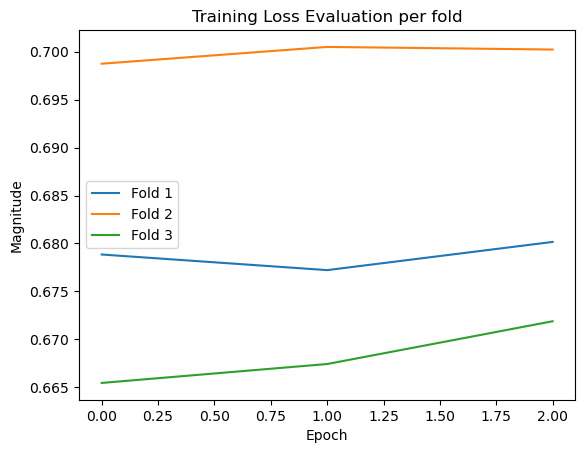

In [23]:
# Plot train losses
ax = plt.axes()
for fold_losses in train_losses:
    plt.plot(fold_losses)
plt.title('Training Loss Evaluation per fold')
plt.xlabel('Epoch')
plt.ylabel('Magnitude')
plt.legend(['Fold ' + str(x) for x in range(1, 11)])
plt.show()

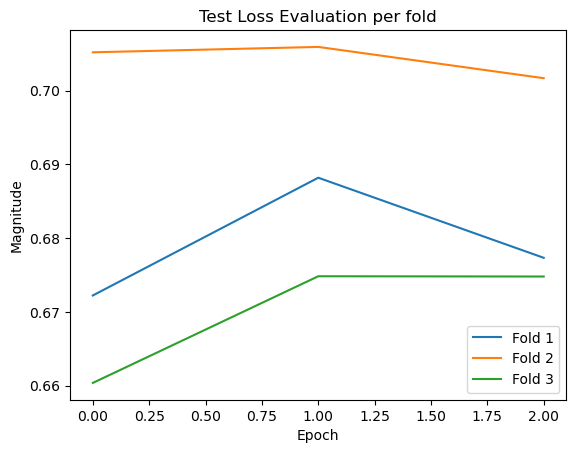

In [24]:
# Plot test losses
ax = plt.axes()
for fold_losses in test_losses:
    plt.plot(fold_losses)
plt.title('Test Loss Evaluation per fold')
plt.xlabel('Epoch')
plt.ylabel('Magnitude')
plt.legend(['Fold ' + str(x) for x in range(1, 11)])
plt.show()

In [25]:
# Get performance metrics by calculcating average of metrics across all folds
print("Final Performance Metrics")
print(f"Accuracy: {np.mean(results_accuracy)}")
print(f"Precision: {np.mean(results_precision)}")
print(f"Sensitivity: {np.mean(results_sensitivity)}")
print(f"Specificity: {np.mean(results_specificity)}")
print(f"F1: {np.mean(results_f1)}")

Final Performance Metrics
Accuracy: 0.5604552992612694
Precision: 0.11940298507462686
Sensitivity: 0.3333333333333333
Specificity: 0.6666666666666666
F1: 0.17582417582417584


### Show Predictions on Sample Images

In [26]:
sample_img_names = ["0000-0-A.tif", "0163-0-P.tif", "0198-0-A.tif"]
sample_img_paths = [(data_dir + "/" + sample_img_names[i]) for i in range(len(sample_img_names))]
sample_classes = [sample_img_names[i][5] for i in range(len(sample_img_names))]
sample_ground_truths = ["No Metastasis" if sample_classes[i] == 0 else "Metastasis" for i in range(len(sample_img_names))]
sample_imgs = [Image.open(img_path).convert('RGB') for img_path in sample_img_paths]
sample_imgs_show = [Image.open(img_path) for img_path in sample_img_paths]

In [27]:
validation_batch = torch.stack([preprocess(img).to(device) for img in sample_imgs])

In [28]:
sample_preds= model(validation_batch).data.numpy()
sample_preds

array([[0.5893913 , 0.41060865],
       [0.58935326, 0.41064677],
       [0.58934623, 0.41065377]], dtype=float32)

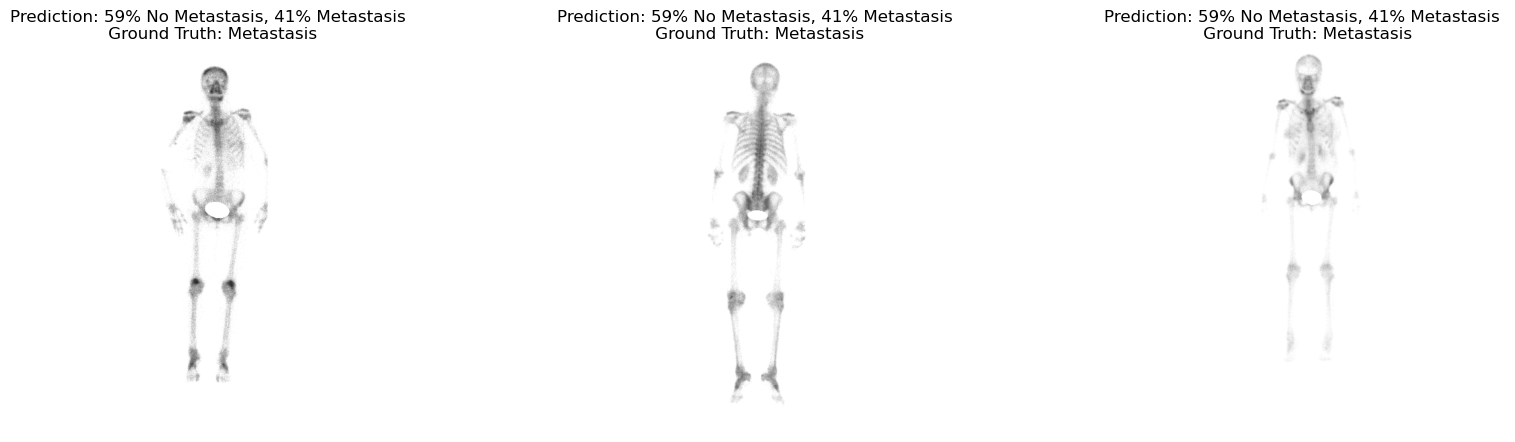

In [29]:
fig, axs = plt.subplots(1, len(sample_imgs_show), figsize=(20, 5))
for i, img in enumerate(sample_imgs_show):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("Prediction: {:.0f}% No Metastasis, {:.0f}% Metastasis \n Ground Truth: {}"
                 .format(100*sample_preds[i,0], 100*sample_preds[i,1], sample_ground_truths[i]))
    ax.imshow(img)

In [30]:
# NOTE: Due to lack of library support for CUDA, this will error if using CUDA
# Get computational complexity
model = model.to("cpu")
stat(model, (3, 646, 220))

[MAdd]: AdaptiveAvgPool2d is not supported!
[Flops]: AdaptiveAvgPool2d is not supported!
[Memory]: AdaptiveAvgPool2d is not supported!
[MAdd]: Sigmoid is not supported!
[Flops]: Sigmoid is not supported!
[Memory]: Sigmoid is not supported!
                                     module name  input shape output shape  params memory(MB)          MAdd         Flops  MemRead(B)  MemWrite(B) duration[%]   MemR+W(B)
0                                      mdsc.conv    3 646 220    3 646 220     9.0       1.63   2,131,800.0   1,279,080.0   1705476.0    1705440.0      11.07%   3410916.0
1                                     mdsc.norm1    3 646 220    3 646 220     6.0       1.63   1,705,440.0     852,720.0   1705464.0    1705440.0       0.00%   3410904.0
2                                     mdsc.norm2    1 646 220    1 646 220     2.0       0.54     568,480.0     284,240.0    568488.0     568480.0       0.00%   1136968.0
3                   mdsc.ds_conv1.depthwise_conv    3 646 220    3 646 220  

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)
